In [1]:
library(tidyverse) #Use required packages
library(cowplot)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
df_data <- read_csv("framingham_data.csv") # Read in data
df_data %>% summary # Summarize Data


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  currentSmoker = col_double(),
  sysBP = col_double()
)




 currentSmoker      sysBP      
 Min.   :0.00   Min.   : 90.0  
 1st Qu.:0.00   1st Qu.:118.0  
 Median :0.00   Median :131.8  
 Mean   :0.25   Mean   :134.9  
 3rd Qu.:0.25   3rd Qu.:148.0  
 Max.   :1.00   Max.   :215.0  

In [3]:
df_data$index <- seq(nrow(df_data)) # Add an index column

#Create a sample variance function to ensure proper calculation
sample_variance <- function(x, sample = TRUE){
    if (sample == TRUE){
        sum((x - mean(x))^2) / (length(x) - 1)
    } else if(sample == FALSE) {
        sum((x - mean(x))^2) / (length(x))
    }
}
#Create pooled sample variance function 
f_pooled_variance <- function(x, y){
    ((length(x) - 1) * sample_variance(x) + 
     (length(y) - 1) * sample_variance(y)) / 
    (length(x) + length(y) - 2)
}

df_data %>% summary # Summarize Data

#Split data based on smoking status
df_smoker <- df_data %>% filter(currentSmoker == 1)
df_nonsmoker <- df_data %>% filter(currentSmoker == 0)

 currentSmoker      sysBP           index       
 Min.   :0.00   Min.   : 90.0   Min.   :  1.00  
 1st Qu.:0.00   1st Qu.:118.0   1st Qu.: 75.75  
 Median :0.00   Median :131.8   Median :150.50  
 Mean   :0.25   Mean   :134.9   Mean   :150.50  
 3rd Qu.:0.25   3rd Qu.:148.0   3rd Qu.:225.25  
 Max.   :1.00   Max.   :215.0   Max.   :300.00  

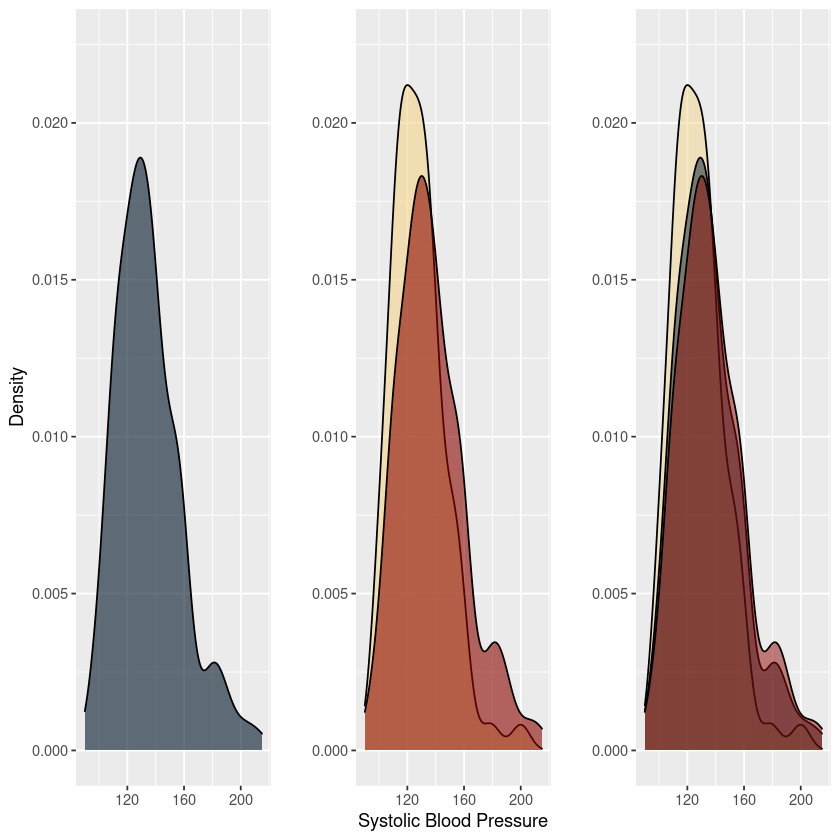

In [4]:
#Plot data
plot_colors <- c("#001427","#708d81","#f4d58d","#bf0603","#8d0801")
#plot_colors <- c("#f04b00","#009b00","#1eb4aa","#f7f6f2","#202020")

y_limits <- c(0, 0.0225)

total_data <- ggplot(df_data) + geom_density(aes(sysBP), 
                                             fill = plot_colors[1],
                                             alpha = 0.6) +
                       ylim(y_limits) + ylab("Density") + xlab("")

sep_data <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = plot_colors[3], alpha = 0.6) + 
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = plot_colors[5], alpha = 0.6) +
                       ylim(y_limits) + ylab("") + xlab("Systolic Blood Pressure")

plot_3 <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = plot_colors[3], alpha = 0.5) + 
                       geom_density(data = df_data, aes(sysBP), 
                                    fill = plot_colors[1], alpha = 0.5) +
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = plot_colors[5], alpha = 0.5) +
                       ylim(y_limits) + ylab("") + xlab("")

plot_grid(total_data, sep_data, plot_3, align = 'vh', 
          hjust = -1,nrow = 1, ncol = 3)

In [5]:
alpha <- 0.05

mu_smoker <- mean(df_smoker$sysBP)
var_smoker <- sample_variance(df_smoker$sysBP)
n_smoker <- length(df_smoker$sysBP)

mu_nonsmoker <- mean(df_nonsmoker$sysBP)
var_nonsmoker <- sample_variance(df_nonsmoker$sysBP)
n_nonsmoker <- length(df_nonsmoker$sysBP)

dof <- (n_smoker + n_nonsmoker - 2)

p_sample_var <- f_pooled_variance(df_smoker$sysBP, 
                                  df_nonsmoker$sysBP)


t_obs <- (mu_smoker - mu_nonsmoker) / (sqrt(p_sample_var/n_smoker + p_sample_var/n_nonsmoker))

t_stat <- qt(alpha / 2, dof)

p_value_obs <- dt(t_obs, dof)

print(p_sample_var)

print(t_obs)

print(p_value_obs)

print(t_stat)

print(c(var_smoker, var_nonsmoker))

[1] 510.0137
[1] -3.041308
[1] 0.00412984
[1] -1.967957
[1] 352.2117 562.1447


In [6]:
set.seed(1)

alpha <- 0.05

#Create a sample variance function to ensure proper calculation
sample_variance <- function(x, sample = TRUE){
    if (sample == TRUE){
        sum((x - mean(x))^2) / (length(x) - 1)
    } else if(sample == FALSE) {
        sum((x - mean(x))^2) / (length(x))
    }
}

test_function <- function (x, y){
    
    sample1 <- sample(x, size = length(x), replace = TRUE)#Bootstrap from first data frame
    sample2 <- sample(y, size = length(y), replace = TRUE)#Bootstrap from second data frame
    
    dof <- length(x) + length(y) - 2 #Determine degrees of freedom
    
    #calculate the mean and variance of the two bootstrap sets
    mu_1 <- mean(sample1)
    var_1 <- sample_variance(sample1, sample = TRUE)
    
    mu_2 <- mean(sample2)
    var_2 <- sample_variance(sample2, sample = TRUE)
    
    #Calculate the pooled sample variance
    pooled_sample <- ((length(x) - 1) * var_1 + (length(y) - 1) * var_2) / (length(x) + length(y) - 2)
    
    #calulate the observed t statistic
    ttest <- (mu_1 - mu_2) / (sqrt(pooled_sample/length(x) + pooled_sample/length(y)))
    
    #Determine whether or not the null hypothesis can be rejected (1 = rejected, 0 = not rejected)
    verdict <- !between(ttest, qt(alpha / 2, dof), qt(1 - alpha / 2, dof))
    
    #Return calculated values
    return(c(mu_1, var_1, mu_2, var_2, ttest, pooled_sample, verdict))
}

In [7]:
set.seed(1980)

sim_data_results <- rep(0, 7)

for (i in seq(1, 1000)){
    #Run the boot strap a 1000 times and store the results in a matrix
    sim_data_results <- rbind(sim_data_results, test_function(df_nonsmoker$sysBP, df_smoker$sysBP))
}

nrow(sim_data_results)

[1] 1001

In [8]:
#Move data into dataframe for easier processing 

df_sim_data <- data.frame(sim_data_results[2:nrow(sim_data_results),]) 
                          
colnames(df_sim_data) = c("Mean Smoker", "Variance Smoker", "Mean NonSmoker", "Variance NonSmoker", 
                          "T statistic", "Pooled Sample Variance", "Null Reject")

In [9]:
#Calculate the number of scenarios where the null was rejected 
sum(df_sim_data$'Null Reject')

[1] 890

In [10]:
df_sim_data %>% head

,Mean Smoker,Variance Smoker,Mean NonSmoker,Variance NonSmoker,T statistic,Pooled Sample Variance,Null Reject
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X,139.1244,574.2902,127.7067,385.2844,3.7289876,527.3559,1
X.1,139.2178,494.1242,129.7000,406.6014,3.2843264,472.3904,1
X.2,138.9822,595.1515,136.3400,567.8254,0.8169715,588.3658,0
X.3,136.1689,507.8932,128.6133,330.2674,2.6312942,463.7848,1
X.4,134.1822,465.8483,127.6467,378.2079,2.3260047,444.0853,1
X.5,138.5489,576.0512,130.8600,497.7673,2.4442675,556.6116,1


In [11]:
str(df_sim_data)

'data.frame':	1000 obs. of  7 variables:
 $ Mean Smoker           : num  139 139 139 136 134 ...
 $ Variance Smoker       : num  574 494 595 508 466 ...
 $ Mean NonSmoker        : num  128 130 136 129 128 ...
 $ Variance NonSmoker    : num  385 407 568 330 378 ...
 $ T statistic           : num  3.729 3.284 0.817 2.631 2.326 ...
 $ Pooled Sample Variance: num  527 472 588 464 444 ...
 $ Null Reject           : num  1 1 0 1 1 1 1 1 1 1 ...


In [12]:
sample_variance <- function(x){
    sum((x - mean(x))^2) / (length(x) - 1)
}

sample_variance(df_data$sysBP)
var(df_data$sysBP)

[1] 524.0852

[1] 524.0852

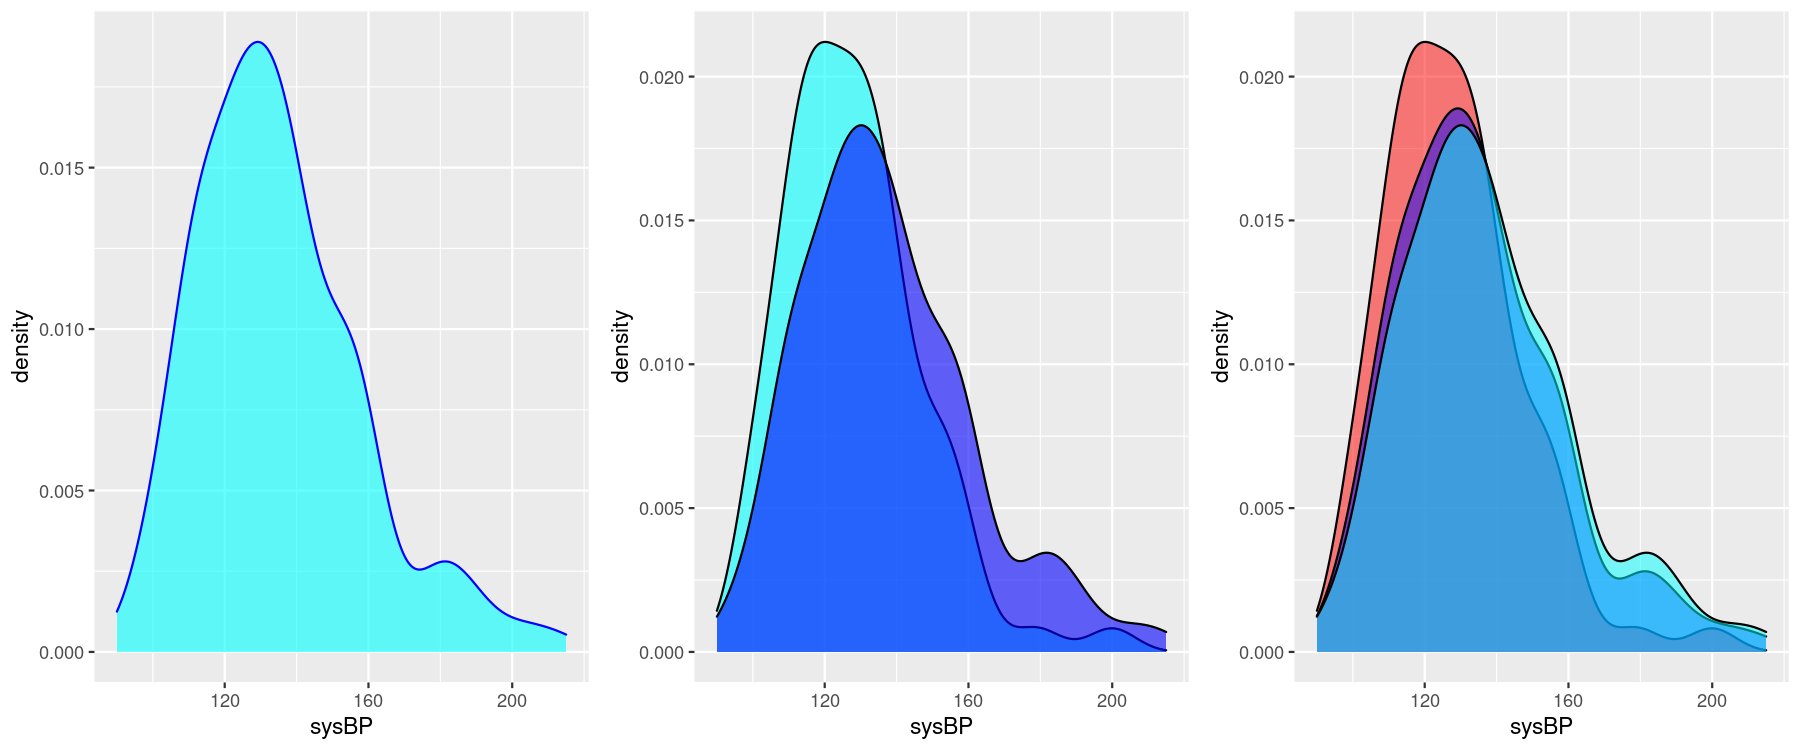

In [13]:
library(cowplot)
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 150)

total_data <- ggplot(df_data) + geom_density(aes(sysBP), 
                                             fill = "cyan",
                                             color = "blue",
                                             alpha = 0.6)

sep_data <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = "cyan", alpha = 0.6) + 
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = "blue", alpha = 0.6)

plot_3 <- ggplot() + geom_density(data = df_smoker, aes(sysBP), 
                                    fill = "red", alpha = 0.5) + 
                       geom_density(data = df_data, aes(sysBP), 
                                    fill = "blue", alpha = 0.5) +
                       geom_density(data = df_nonsmoker, aes(sysBP), 
                                    fill = "cyan", alpha = 0.5)

plot_grid(total_data, sep_data, plot_3, align = 'vh', 
          hjust = -1,nrow = 1, ncol = 3)

In [14]:
library(e1071)
sd(df_data$sysBP)
mean(df_data$sysBP)
kurtosis(df_data$sysBP)
skewness(df_data$sysBP)

[1] 22.89291

[1] 134.935

[1] 0.8123606

[1] 0.8797915

In [15]:
qchisq(0.95, 3)

[1] 7.814728

In [16]:
satterth <- function(s1, s2, n1, n2){
    term1 <- s1/n1
    term2 <- s2/n2
    nu <- (term1 + term2)^2 / ((term1/(n1 - 1)) + (term2/(n2 - 1)))
    return(floor(nu))
}

In [17]:
satterth(var_smoker, var_nonsmoker, n_smoker, n_nonsmoker)

[1] 693

In [18]:
dof_1 <- (n_smoker + n_nonsmoker - 2)

p_sample_var_1 <- f_pooled_variance(df_smoker$sysBP, 
                                    df_nonsmoker$sysBP)


t_obs_1 <- (mu_smoker - mu_nonsmoker) / (sqrt(p_sample_var_1) * sqrt(1/n_smoker + 1/n_nonsmoker))

t_stat_1 <- qt(alpha / 2, dof_1)

p_value_obs_1 <- dt(t_obs_1, dof_1)

#Two Sample T-test - Difference Variance Sample Variance - P-value

dof_2 <- satterth(var_smoker, var_nonsmoker, n_smoker, n_nonsmoker)

t_obs_2 <- (mu_smoker - mu_nonsmoker) / (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker))

t_stat_2 <- qt(alpha / 2, dof_2)

p_value_obs_2 <- dt(t_obs_2, dof_2)

In [25]:
# Confidence Limits

diff_mu <- mu_smoker - mu_nonsmoker

#Pooled Sample varince

CI_pooled <- t_stat_1 * (sqrt(p_sample_var_1/n_smoker + p_sample_var_1/n_nonsmoker))

#Non pooled Sample varince

CI_nonpooled <- t_stat_2 * (sqrt(var_nonsmoker/n_smoker + var_nonsmoker/n_nonsmoker))

In [26]:
CI_pooled
CI_nonpooled

[1] -5.925775

[1] -6.206833

In [31]:
round(c(diff_mu + CI_pooled, diff_mu - CI_pooled), 2)

round(c(diff_mu + CI_nonpooled, diff_mu - CI_nonpooled), 2)

[1] -15.08  -3.23

[1] -15.36  -2.95